In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from matplotlib import rc
from matplotlib import colors
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy
import matplotlib

## Constants and Variables

In [ ]:
THRESOLD = 0

In [ ]:
Forest:
    size: int 
    forest_type: str
    maturity: str 
Cell:
    curr_age: int
    max_age: int #maximum age of a tree, DRAWN FROM PROB DISTRIBUTION
    curr_cmass: int #carbon mass
    cs_rate: float #carbon sequestration rate

In [89]:
@dataclass
class Cell:
    def __init__(self, max_age: int):
        self.max_age = max_age
        temp_age = np.random.normal(0.5 * self.max_age, 0.2)
        self.curr_age = 1 if temp_age < 0 else temp_age
        self.carbon_mass = 0
        self.cs_rate = 0
    
    def set_cs_rate(self, density: float):
        pass
    
    def get_cs(self):
        return self.cs_rate
        
    def grow(self):
        self.curr_age += 1
        self.carbon_mass += self.cs_rate
            
    def get_mass(self):
        return self.carbon_mass
    
    def cut(self) -> None:
        self.curr_age = 0
        self.carbon_mass = 0

def csr_mat(x):
    return (6.37*x) - (14.27*x**2) + (8.31*x**3)

class TropicalCell(Cell):
    def __init__(self, max_age: int):
        self.max_age = max_age
        temp_age = np.random.normal(0.5 * self.max_age, 0.2)
        self.curr_age = 1 if temp_age < 0 else temp_age
        mu = (0.5 * np.pi * 40 * 43 / 2000) * (self.curr_age / self.max_age)
        self.carbon_mass = np.random.normal(mu, 0.1 * mu)  
        
    def set_cs_rate(self, density: float):
        mat = csr_mat(self.curr_age / self.max_age)
        mu = (0.5 * np.pi * 40 * 43 / 2000) * (self.curr_age / self.max_age)
        self.cs_rate = (mat * density) * np.random.normal(mu, 0.1 * mu)  
        
class BorealCell(Cell):
    def __init__(self, max_age: int):
        self.max_age = max_age
        temp_age = np.random.normal(0.5 * self.max_age, 0.2)
        self.curr_age = 1 if temp_age < 0 else temp_age
        mu = (0.5 * np.pi * (1.5**2) * 80 * 34 / 2000) * (self.curr_age / self.max_age)
        self.carbon_mass = np.random.normal(mu, 0.1 * mu)   
        
    def set_cs_rate(self, density: float):
        mat = csr_mat(self.curr_age / self.max_age)
        mu = (0.5 * np.pi * (1.5**2) * 80 * 34 / 2000) * (self.curr_age / self.max_age)
        self.cs_rate = (mat * density) * np.random.normal(mu, 0.1 * mu)   
        
class TemperateCell(Cell):
    def __init__(self, max_age: int):
        self.max_age = max_age
        temp_age = np.random.normal(0.5 * self.max_age, 0.2)
        self.curr_age = 1 if temp_age < 0 else temp_age
        mu = (0.5 * np.pi * (1.25**2) * 60 * 41 / 2000) * (self.curr_age / self.max_age)
        self.carbon_mass = np.random.normal(mu, 0.1 * mu)  
        self.set_cs_rate()
    
    def set_cs_rate(self, density: float):
        mat = csr_mat(self.curr_age / self.max_age)
        mu = (0.5 * np.pi * (1.25**2) * 60 * 41 / 2000) * (self.curr_age / self.max_age)
        self.cs_rate = (mat * density) * np.random.normal(mu, 0.1 * mu) 

Creating forests given inputs

In [90]:
@dataclass
class Forest:
    def __init__(self, land, size: int, max_time: int, maturity: str, plotting: bool, ftype: str):
        self.size = size
        self.maturity = maturity
        self.plotting = plotting
        self.max_time = max_time
        self.land = land
        self.ftype = ftype
        self.carbon_data = []
        
    def simulate(self) -> None:
        for t in range(self.max_time):
            # if i % 40 == 0:
            #     self.deforest()
            rand_order = np.random.permutation([(x, y) for x in range(self.size) for y in range(self.size)])
            for (ii, ij) in rand_order:
                density = self.land[ii, ij].get_mass() / self.get_surrounding_density(ii, ij)
                self.land[ii, ij].set_cs_rate(density)
                self.land[ii, ij].grow()
            self.carbon_data.append(self.get_total_carbon_mass())
            if self.plotting:
                if t % 10 == 0: 
                    self.plot_2d_mass(time=t)
        
    def deforest(self) -> None:
        for (ii, ij) in np.ndindex(self.land.shape):
            if self.land[ii, ij].get_mass() > THRESHOLD:
                self.land[ii, ij].cut()
                
    def get_surrounding_density(self, ii: int, ij: int) -> float:
        if ii == 0: 
            if ij == 0: #upper left corner
                return (self.land[ii + 1, ij].get_mass() + self.land[ii, ij + 1].get_mass() \
                       + self.land[ii + 1, ij + 1].get_mass()) / 3
            elif ij == self.size - 1: #upper right corner
                return (self.land[ii + 1, ij].get_mass() + self.land[ii, ij - 1].get_mass() \
                       + self.land[ii + 1, ij - 1].get_mass()) / 3
            else: #first row
                return (self.land[ii, ij - 1].get_mass() + self.land[ii, ij + 1].get_mass() \
                       + self.land[ii + 1, ij - 1].get_mass() + self.land[ii + 1, ij].get_mass() \
                       + self.land[ii + 1, ij + 1].get_mass()) / 5
        elif ii == self.size - 1:
            if ij == 0: #lower left corner
                return (self.land[ii - 1, ij].get_mass() + self.land[ii, ij + 1].get_mass() \
                       + self.land[ii - 1, ij - 1].get_mass()) / 3
            elif ij == self.size - 1: #lower right corner
                return (self.land[ii, ij - 1].get_mass() + self.land[ii - 1, ij - 1].get_mass() \
                       + self.land[ii, ij].get_mass()) / 3
            else: #last row
                return (self.land[ii, ij - 1].get_mass() + self.land[ii, ij + 1].get_mass() \
                       + self.land[ii - 1, ij - 1].get_mass() + self.land[ii - 1, ij].get_mass() \
                       + self.land[ii - 1, ij + 1].get_mass()) / 5
        elif ij == 0: #first column
            return (self.land[ii - 1, ij].get_mass() + self.land[ii - 1, ij + 1].get_mass() \
                   + self.land[ii, ij + 1].get_mass() + self.land[ii + 1, ij].get_mass() \
                   + self.land[ii + 1, ij + 1].get_mass()) / 5
        elif ij == self.size - 1: #last column
            return (self.land[ii - 1, ij].get_mass() + self.land[ii - 1, ij - 1].get_mass() \
                   + self.land[ii, ij - 1].get_mass() + self.land[ii + 1, ij].get_mass() \
                   + self.land[ii + 1, ij - 1].get_mass()) / 5
        else: #middle cells
            return (self.land[ii - 1, ij - 1].get_mass() + self.land[ii - 1, ij].get_mass() \
                   + self.land[ii - 1, ij + 1].get_mass() + self.land[ii, ij - 1].get_mass() \
                   + self.land[ii, ij + 1].get_mass() + self.land[ii + 1, ij - 1].get_mass() \
                   + self.land[ii + 1, ij].get_mass() + self.land[ii + 1, ij + 1].get_mass()) / 8
                
    def get_total_carbon_mass(self) -> int:
        return sum([self.land[ii, ij].get_mass() for (ii, ij) in np.ndindex(self.land.shape)])
    
    def plot_carbon(self) -> None:
        self.simulate()
        x = list(range(1, self.max_time + 1))
        sns.set_style(style = 'whitegrid')
        ax = sns.lineplot(x=x, y=self.carbon_data, color='#81A1C1')
        ax.set(xlabel='Time', ylabel='Total Carbon Sequestered')
        plt.xlim(0)
        plt.ylim(0)
        plt.show()
        #plt.savefig("./images/" + self.ftype + "/cs.jpeg")
        
    def populate_state(self):
        ret = np.array([[0 for _ in range(self.size)] for _ in range(self.size)])
        for i in range(self.size):
            for j in range(self.size):
                bm = self.land[i, j].get_mass()
                if 0 < bm and bm <= 100:
                    ret[i, j] = 1
                elif 100 < bm and bm <= 200:
                    ret[i, j] = 2
                elif 200 < bm and bm <= 300:
                    ret[i, j] = 3
                elif 300 < bm and bm <= 400:
                    ret[i, j] = 4
                elif 400 < bm and bm <= 500:
                    ret[i, j] = 5
                elif 500 < bm and bm <= 600:
                    ret[i, j] = 6      
        return ret
        
    def plot_2d_mass(self, time=0) -> None:
        curr_state = self.populate_state()
        from matplotlib.colors import LinearSegmentedColormap
        num_colors = 6
        col = ['#81A1C1', '#D8DEE9', '#5E81AC', '#4C566A', '#3B4252', '#2E3440']
        cmap = LinearSegmentedColormap.from_list('', col, num_colors)
        ax = sns.heatmap(curr_state, cmap=cmap, vmin=0, vmax=num_colors, square=True, cbar=False, \
                         xticklabels=False, yticklabels=False)
        plt.show()
        
class Tropical(Forest):
    def __init__(self, size: int, max_time: int, maturity: str, plotting: bool, ftype="tropical"):
        super().__init__(np.array([[TropicalCell(np.random.normal(95, 15)) for _ in range(size)] for _ in range(size)]), \
                         size, max_time, maturity, plotting, ftype="tropical")
        
class Boreal(Forest):
    def __init__(self, size: int, max_time: int, maturity: str, plotting: bool, ftype="boreal"):
        super().__init__(np.array([[BorealCell(np.random.normal(150, 25)) for _ in range(size)] for _ in range(size)]), \
                         size, max_time, maturity, plotting, ftype="boreal")
        
class Temperate(Forest):
    def __init__(self, size: int, max_time: int, maturity: str, ftype="temperate"):
        super().__init__(np.array([[Temperate(np.random.normal(120, 20)) for _ in range(size)] for _ in range(size)]), \
                         size, max_time, maturity, ftype="temperate")

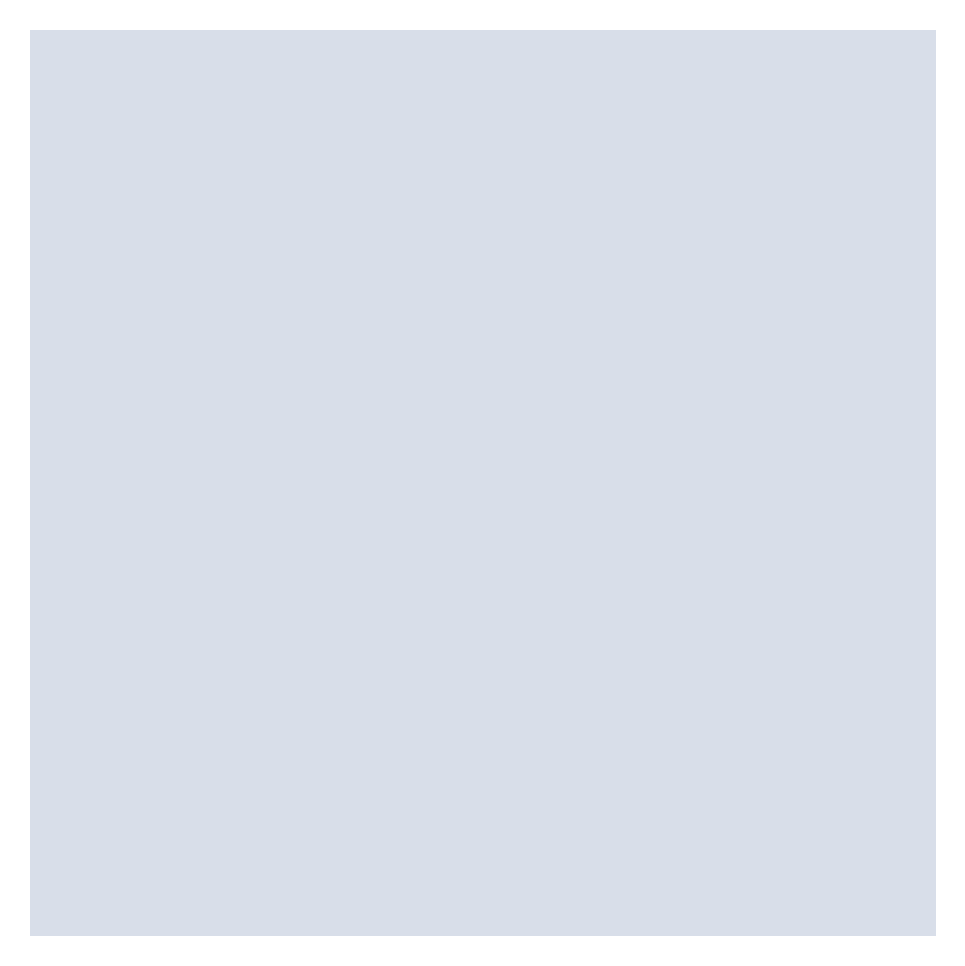

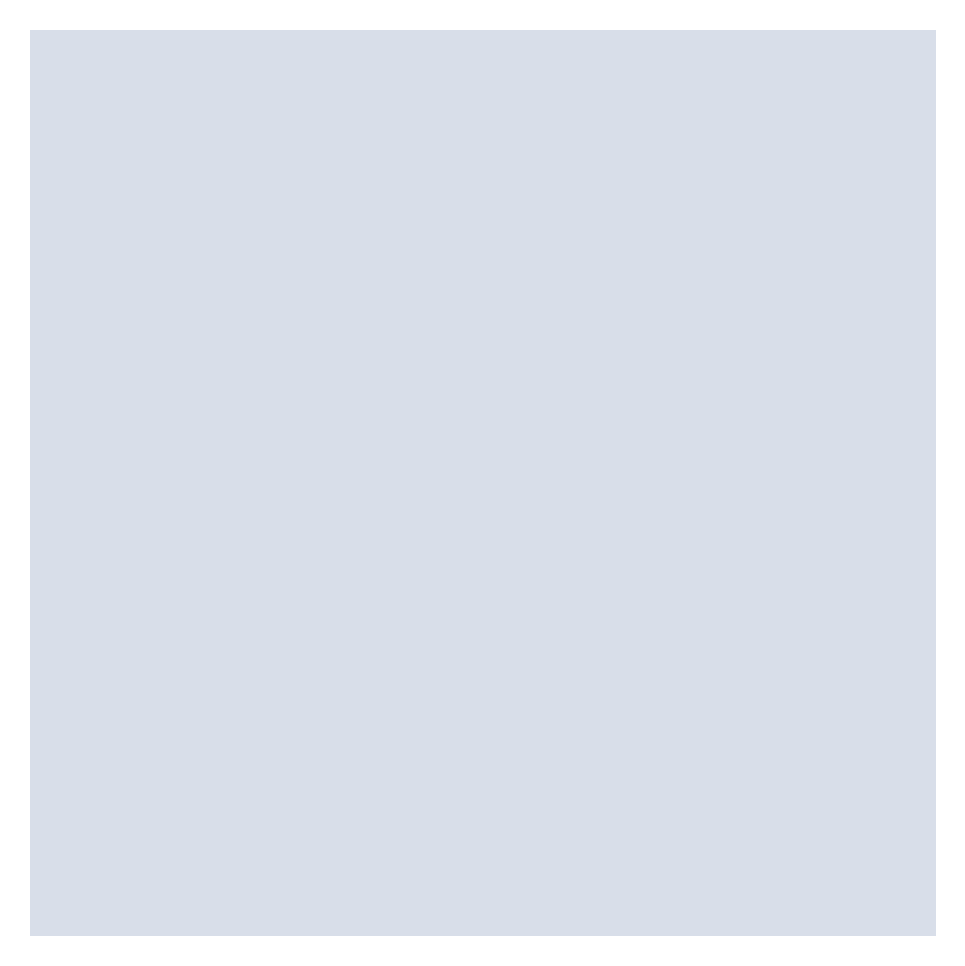

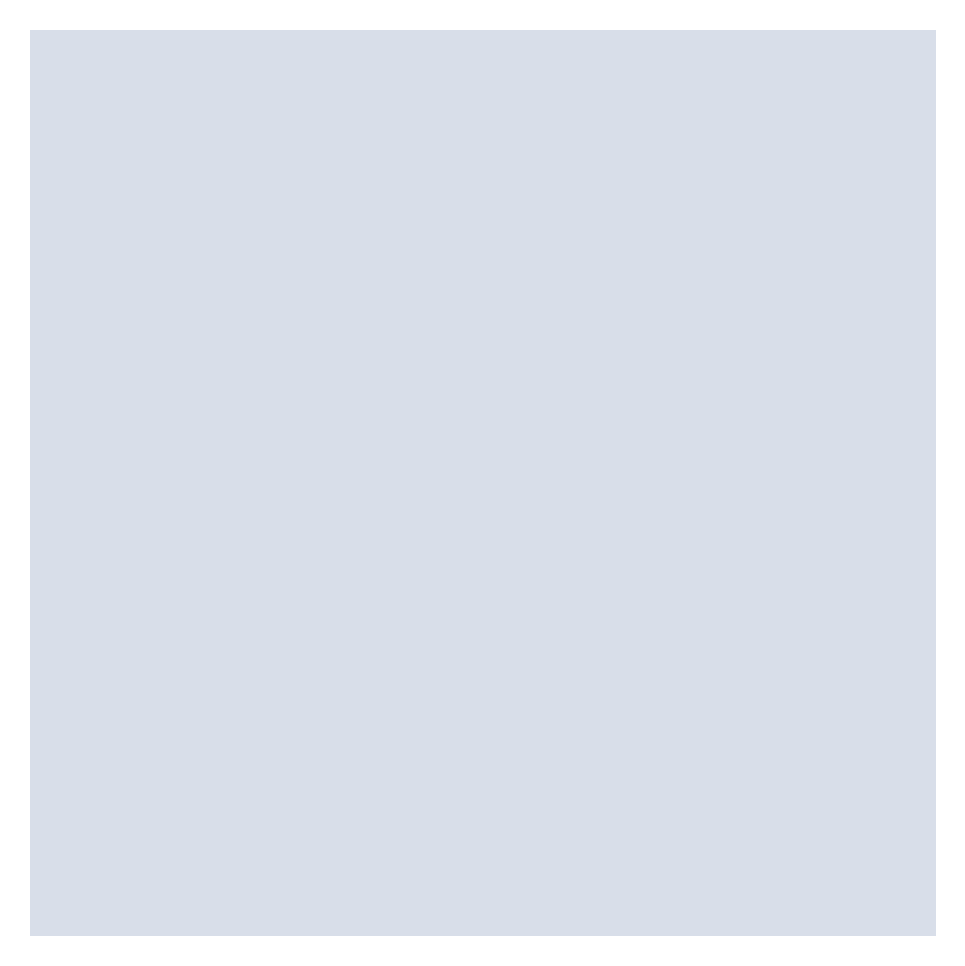

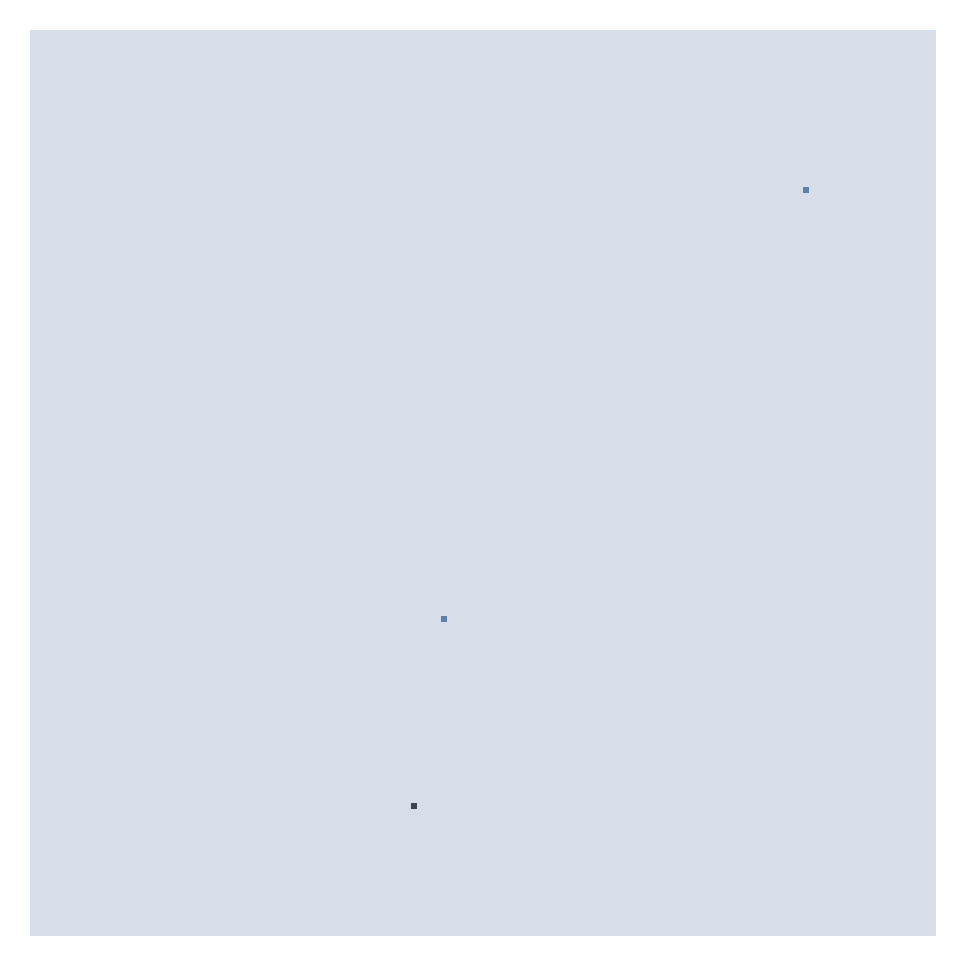

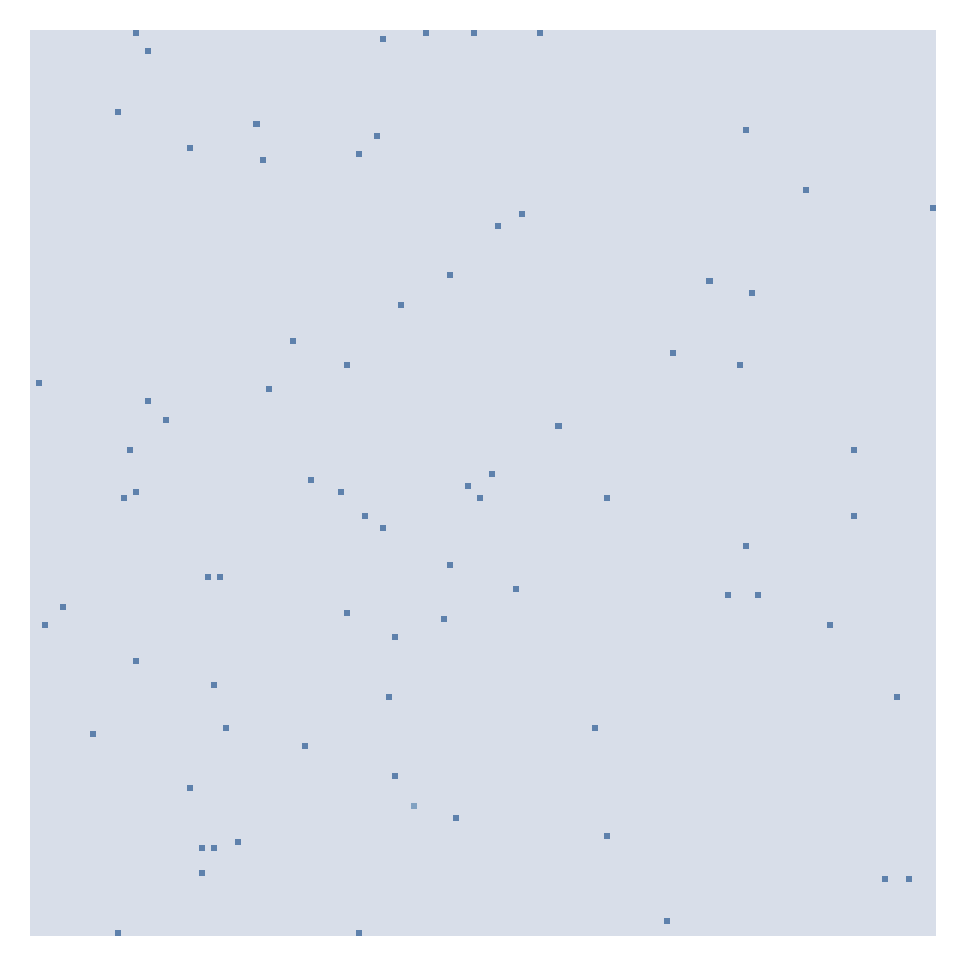

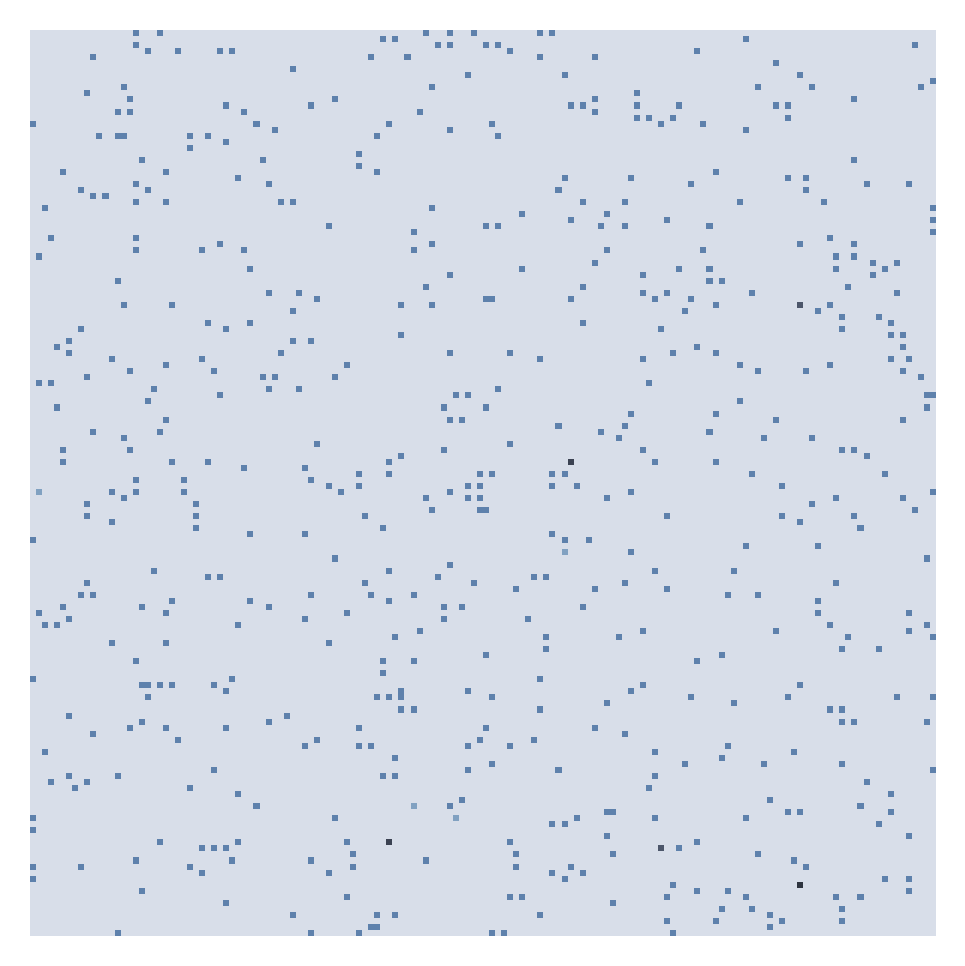

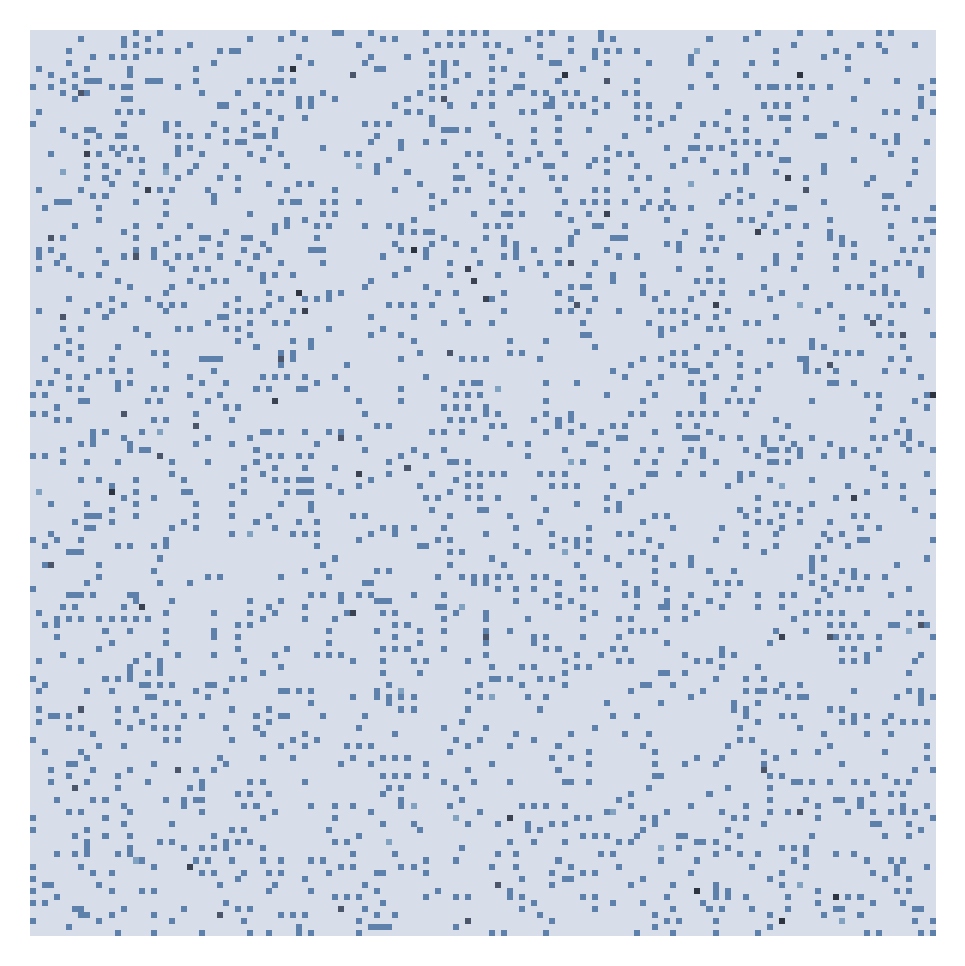

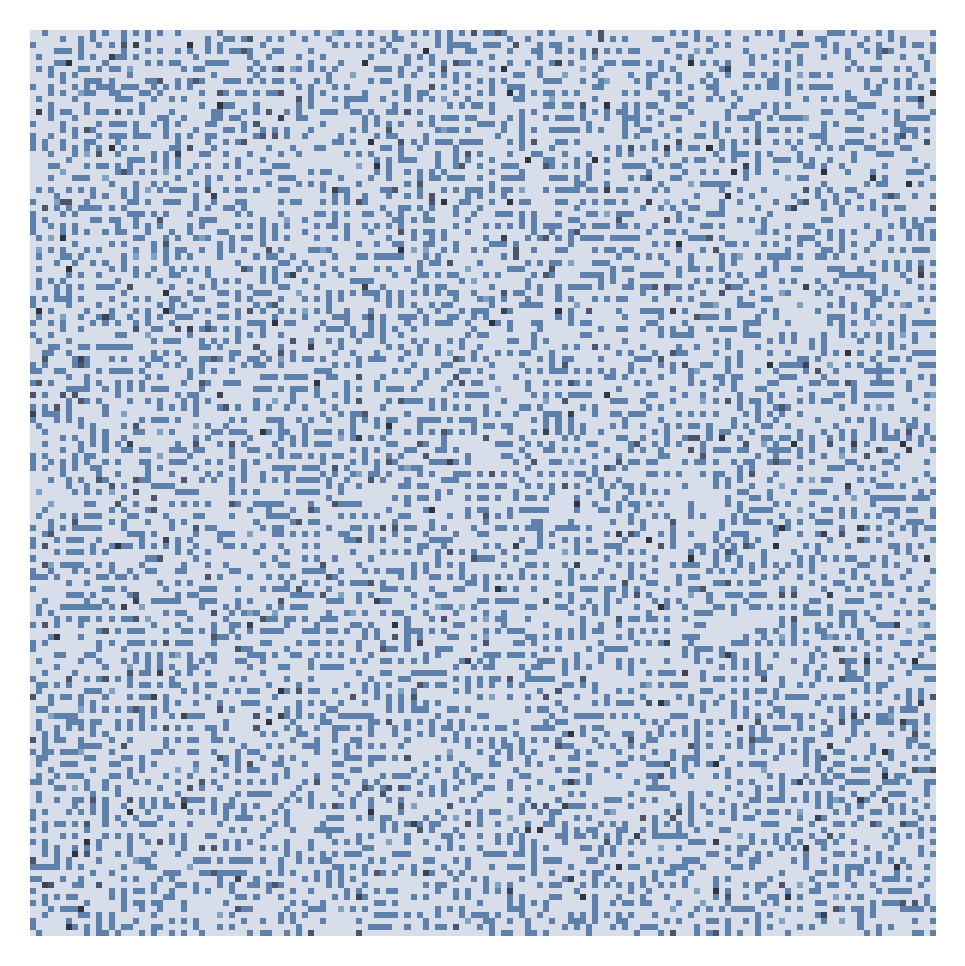

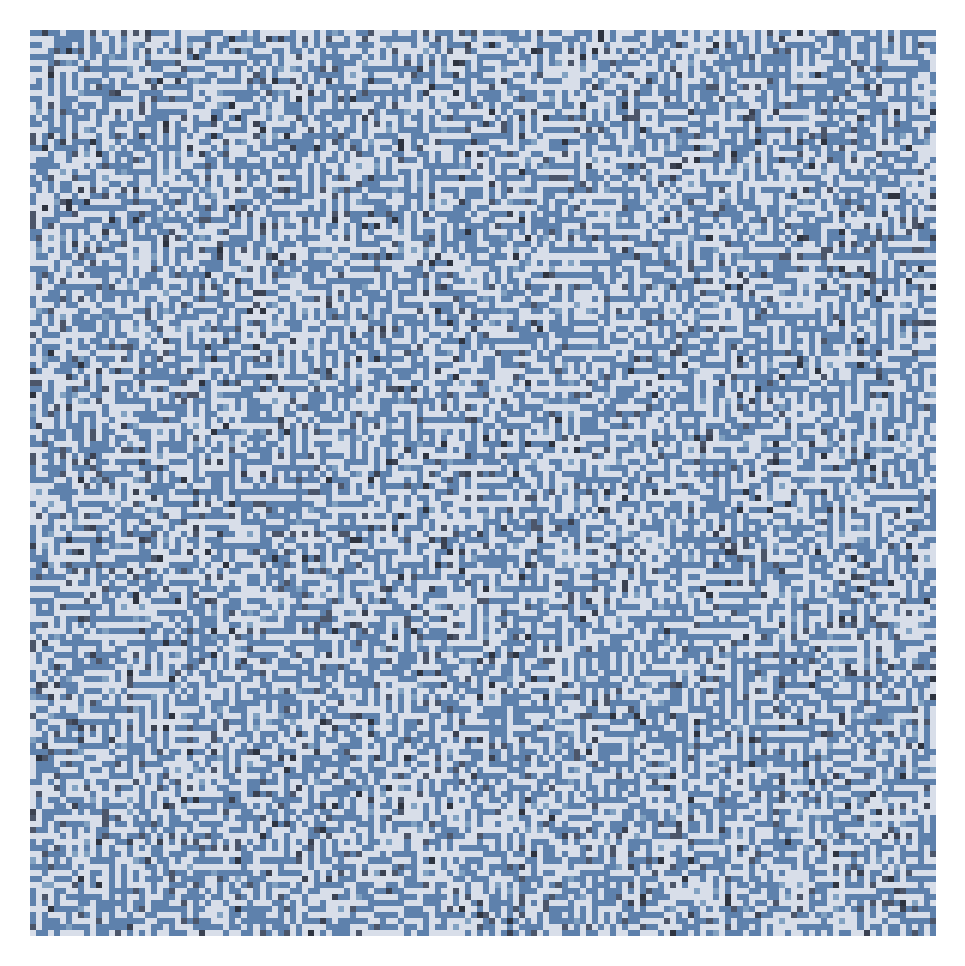

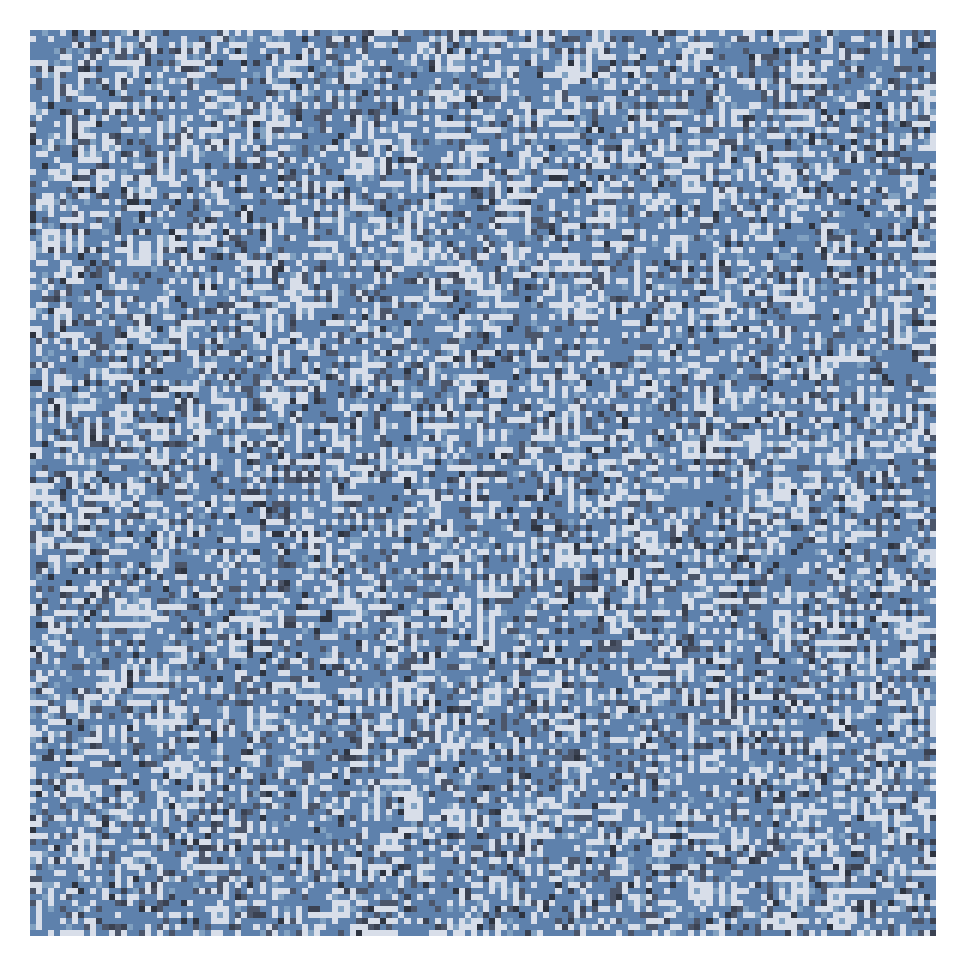

In [91]:
test = Boreal(150, 100, "test", True, ftype="Tropical")
test.simulate()

In [30]:
Graphs:
    Carbon currently in forest
    Carbon currently in wood products

SyntaxError: invalid syntax (692799266.py, line 1)